Policy (random, before training):
00,R,[-0.17 -0.07 +0.17 -0.27] 01,R,[-0.18 -0.07 +0.17 -0.27] 02,R,[-0.17 -0.07 +0.17 -0.27] 03,R,[-0.17 -0.07 +0.17 -0.27] 
04,R,[-0.17 -0.07 +0.17 -0.27] 05,R,[-0.17 -0.07 +0.17 -0.27] 06,R,[-0.17 -0.07 +0.17 -0.27] 07,R,[-0.17 -0.07 +0.17 -0.27] 
08,R,[-0.17 -0.07 +0.17 -0.27] 09,R,[-0.17 -0.07 +0.17 -0.27] 10,R,[-0.17 -0.07 +0.17 -0.27] 11,R,[-0.17 -0.07 +0.17 -0.27] 
12,R,[-0.17 -0.07 +0.17 -0.27] 13,R,[-0.17 -0.07 +0.17 -0.27] 14,R,[-0.17 -0.07 +0.17 -0.27] 15,R,[-0.17 -0.07 +0.17 -0.27] 
Policy (trained):
00,D,[+0.53 +0.59 +0.56 +0.54] 01,R,[+0.57 +0.04 +0.64 +0.54] 02,D,[+0.38 +0.74 +0.40 +0.47] 03,R,[+0.41 +0.11 +0.50 +0.49] 
04,D,[+0.59 +0.66 -0.01 +0.57] 05,D,[+0.66 +0.67 +0.16 +0.42] 06,D,[+0.44 +0.81 -0.07 +0.59] 07,D,[+0.52 +0.73 +0.17 +0.36] 
08,R,[+0.66 -0.00 +0.73 +0.58] 09,D,[+0.64 +0.81 +0.81 +0.01] 10,D,[+0.73 +0.90 +0.02 +0.65] 11,D,[+0.51 +1.01 +0.14 +0.39] 
12,R,[+0.38 +0.35 +0.81 +0.58] 13,R,[+0.18 +0.77 +0.90 +0.72] 14,R,[+0.81

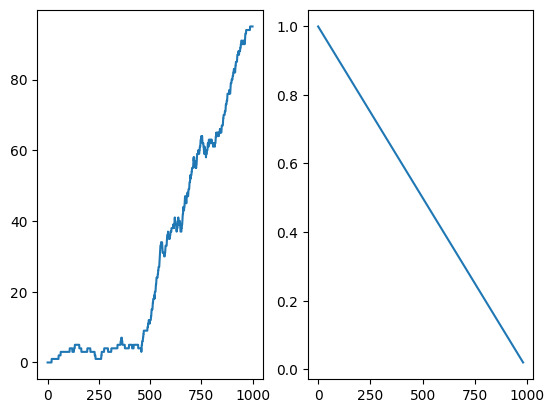

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
import math

# Define model
class DQN(nn.Module):
    def __init__(self, input_shape, out_actions):
        super().__init__()

        # https://poloclub.github.io/cnn-explainer/
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into a single vector
            # After flattening the matrix into a vector, pass it to the output layer. To determine the input shape, use the print() statement in forward()
            nn.Linear(in_features=10*1*1, out_features=out_actions)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        # print(x.shape)  # Use this to determine input shape of the output layer.
        x = self.layer_stack(x)
        return x

# Use this to check if DQN is valid
# temp_dqn = DQN(3, 4) # (3 channels, 4 actions)
# temp_tensor = torch.randn(1,3,4,4)  # (batch, channel, row, column)
# temp_dqn(temp_tensor)


# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

# FrozeLake Deep Q-Learning
class FrozenLakeDQL():
    # Hyperparameters (adjustable)
    learning_rate_a = 0.001         # learning rate (alpha)
    discount_factor_g = 0.9         # discount rate (gamma)
    network_sync_rate = 10          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 1000       # size of replay memory
    mini_batch_size = 32            # size of the training data set sampled from the replay memory

    # Neural Network
    loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
    optimizer = None                # NN Optimizer. Initialize later.

    ACTIONS = ['L','D','R','U']     # for printing 0,1,2,3 => L(eft),D(own),R(ight),U(p)

    # Train the FrozeLake environment
    def train(self, episodes, render=False, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        # Create policy and target network.
        policy_dqn = DQN(input_shape=3, out_actions=num_actions)
        target_dqn = DQN(input_shape=3, out_actions=num_actions)

        # Make the target and policy networks the same (copy weights/biases from one network to the other)
        target_dqn.load_state_dict(policy_dqn.state_dict())

        print('Policy (random, before training):')
        self.print_dqn(policy_dqn)

        # Policy network optimizer. "Adam" optimizer can be swapped to something else.
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        # List to keep track of rewards collected per episode. Initialize list to 0's.
        rewards_per_episode = np.zeros(episodes)

        # List to keep track of epsilon decay
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count=0

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):

                # Select action based on epsilon-greedy
                if random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
                else:
                    # select best action
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                # Execute action
                new_state,reward,terminated,truncated,_ = env.step(action)

                # Save experience into memory
                memory.append((state, action, new_state, reward, terminated))

                # Move to the next state
                state = new_state

                # Increment step counter
                step_count+=1

            # Keep track of the rewards collected per episode.
            if reward == 1:
                rewards_per_episode[i] = 1

            # Check if enough experience has been collected and if at least 1 reward has been collected
            if len(memory)>self.mini_batch_size and np.sum(rewards_per_episode)>0:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)

                # Decay epsilon
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0

        # Close environment
        env.close()

        # Save policy
        torch.save(policy_dqn.state_dict(), "frozen_lake_dql_cnn.pt")

        # Create new graph
        plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        plt.plot(sum_rewards)

        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)

        # Save plots
        plt.savefig('frozen_lake_dql_cnn.png')

    # Optimize policy network
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:

            if terminated:
                # Agent either reached goal (reward=1) or fell into hole (reward=0)
                # When in a terminated state, target q value should be set to the reward.
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state)).max()
                    )

            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state))
            
            # Adjust the specific action to the target that was just calculated. 
            # Target_q[batch][action], hardcode batch to 0 because there is only 1 batch.
            target_q[0][action] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    '''
    Converts a state (int) to a tensor representation for input into CNN: tensor[batch][channel][row][column].
    The FrozenLake 4x4 map has 4x4=16 states numbered from 0 to 15. 
    Example:
    Input: state=1
    Return: tensor([[[[0., .9, 0., 0.],
                      [0., 0., 0., 0.],
                      [0., 0., 0., 0.],
                      [0., 0., 0., 0.]],
                      repeat above matrix 2 more times
                                       ]])
        where .9 is the normalize color code of Red
    '''
    def state_to_dqn_input(self, state:int)->torch.Tensor:
        # create empty tensor[batch][channel][row][column].
        # Converting 1 state, so batch is always 1.
        # Channels = 3, Red Green Blue (RGB).
        # FrozenLake map has 4 rows x 4 columns.
        input_tensor = torch.zeros(1,3,4,4)

        # convert state to row and column
        r=math.floor(state/4)
        c=state-r*4

        # Set color for each channel. Normalize it. The color selected here is (R,G,B) = (245,66,120)
        input_tensor[0][0][r][c] = 245/255
        input_tensor[0][1][r][c] = 66/255
        input_tensor[0][2][r][c] = 120/255
        
        # To see what the image looks like, uncomment out the following lines AND put a break point at the return statement.
        # pic = input_tensor.squeeze()      # input_tensor[batch][channel][row][column] - use squeeze to remove the batch level
        # pic = torch.movedim(pic, 0, 2)    # rearrange from [channel][row][column] to [row][column][channel]
        # plt.imshow(pic)                   # plot the image
        # plt.show()                        # show the image
        
        return input_tensor



    # Run the FrozeLake environment with the learned policy
    def test(self, episodes, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        # Load learned policy
        policy_dqn = DQN(input_shape=3, out_actions=num_actions)
        policy_dqn.load_state_dict(torch.load("frozen_lake_dql_cnn.pt"))
        policy_dqn.eval()    # switch model to evaluation mode

        print('Policy (trained):')
        self.print_dqn(policy_dqn)

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):
                # Select best action
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)

        env.close()

    # Print DQN: state, best action, q values
    def print_dqn(self, dqn):

        # Loop each state and print policy to console
        for s in range(16):
            #  Format q values for printing
            q_values = ''
            for q in dqn(self.state_to_dqn_input(s))[0].tolist():
                q_values += "{:+.2f}".format(q)+' '  # Concatenate q values, format to 2 decimals
            q_values=q_values.rstrip()              # Remove space at the end

            # Map the best action to L D R U
            best_action = self.ACTIONS[dqn(self.state_to_dqn_input(s)).argmax()]

            # Print policy in the format of: state, action, q values
            # The printed layout matches the FrozenLake map.
            print(f'{s:02},{best_action},[{q_values}]', end=' ')
            if (s+1)%4==0:
                print() # Print a newline every 4 states

if __name__ == '__main__':

    frozen_lake = FrozenLakeDQL()
    is_slippery = False
    frozen_lake.train(1000, is_slippery=is_slippery)
    frozen_lake.test(10, is_slippery=is_slippery)